# Proiect Congestion Control

Vom folosi acest notebook pentru vizualizarea comportamentului algoritmului implementat. Pentru realizarea graficelor aferent este folosita biblioteca `matplotlib`. In Jupyter comenzile precedate de `!` sunt rulate din bash. Punctajul acordat este calculat pe trei categorii: throughput, latency si fariness.

> Vom considera MSS = 1500 bytes

### Inainte de a rula simulatorul

Vom folosi matplotlib pentru a realiza graficele. Rezultatele rularii simulatorului se vor gasi in directorul `tmp`.

In [66]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [67]:
# Note: comenzile prefixate cu ! sunt rulate in Bash, nu in Python!
!mkdir -p tmp/t

In [68]:
# O sa intalnim des apelul functiei format pe un string. Aceasta este similara cu %s sau %d in printf.

string = "ceva{}".format(4)
print(string)

ceva4


### Cod pentru desenarea graficelor

In [69]:
import matplotlib.pyplot as plt

# Fiecare fisier .dat dim tmp contine date despre o conexiune. Acestea au urmatorul format:
# 0.100000000 Type CC_SINK ID 0 Ev RATE CAck 3643500 CWND 1776791 Rate 36435000
# De exemplu la indexul 0 se afla timestamp-ul, iar la indexul 12 throughput-ul

def plot_generic(axs, index_f1, index_f2, ylabel, xlabel, scale_y, num_cons, data_folder="tmp/t/"):
    for i in range(num_cons):
        x1, y1 = [], []
        # Citeste throughput-ul din fisierul aferent conexiunii i
        with open("{}{}.dat".format(data_folder, i)) as f:
            for line in f:
                values = line.split()
                x1.append(float(values[index_f1]))
                y1.append(float(values[index_f2]) * scale_y)
        axs.plot(x1, y1, '-', label='Conn {}'.format(i))
        axs.legend()
    
def plot_throughput(axs, num_cons):
    axs.set_ylabel('Throughput (Mbps)')
    axs.set_xlabel('Time (s)')
    # Valorile din fisieri sunt in byes asa ca le inmultim cu 8/1000000 ca sa trecem in Mb/s
    plot_generic(axs, 0, 12, 'Throughput', 'Time (s)', 8 / 1000000, num_cons)

def plot_cwnd(axs, num_cons):
    axs.set_ylabel('CWND (MSS)')
    axs.set_xlabel('Time (s)')
    plot_generic(axs, 0, 10, 'CWND (MSS)', 'Time (s)', 1/1500, num_cons)

def plot_router_queue(axs, max_queue_size, data_folder="tmp/t/"):
    axs.set_ylabel('Packets in Queue (MSS) ')
    axs.set_xlabel('Time (s)')
    x1, y1 = [], []
    with open("{}q.dat".format(data_folder)) as f:
        for line in f:
            values = line.split()
            x1.append(float(values[0]))
            y1.append(float(values[12]) * 1/1500)
        
        axs.hlines(y=max_queue_size, xmin=0, xmax=x1[-1], linewidth=2, color='r')
        axs.plot(x1, y1, '-')    

### Masurarea performantei algoritmului de congestion control

Urmatoarele celule compileaza si ruleaza simulatorul. Ulterior vom folosii functile definite in sectiunile precedente pentru a realiza graficele valorilor CWND, viteza de transmisie, fairness, coada de pachete din router etc. Acestea ne vor ajuta in a intelege performanta protocolului nostru.

In [70]:
MSS = 1500

In [71]:
# Inainte de a rula o simulare, vom chema make
!make -s

# Rulam simulatorul (vezi main_dumbell_cc.cpp)
# -cons numarul de conexiuni
# -end (ms) timpul de rulare al experimentului
# -latency (ms) latenta link-urilor
# -bandwidth (Mbs) bandwidth-ul link-urilor
# -q dimensiunea cozii in MSS
# -startdelta (ms) de la ce timp sa porneasca o noua conexiune
# -log (ms) intervalul la care se fac masuratori pentrum cwnd
# -bandwidth (mbps) seteaza bandwidth-ul linkurilor
# -ecn BDP BDP (pentru a da enable la functionalitatea de ecn, BDP in masurat in pachete (MSS))
num_cons = 3
MSS = 1500
latency = 5 # in ms
bandwidth = 5 # in Mbs
# bandwidth * 10**9 - bandwidth in bps
# latency / 1000 - latency in s
# MSS * 8 - dimensiune MSS in bits
bdp_in_mss = int((latency / 1000) * (bandwidth * 10 ** 6) / (MSS * 8))
router_queue_size = 10 * bdp_in_mss # 10 BDP
# Rulam simulatorul din bash. ./scripts/parse.sh logout.dat parseaza rezultatele si le scrie in format human readable in folder-ul 
! ./htsim_dumbell_cc -conns {num_cons} -end 20000 -log 100 -q {router_queue_size} -latency {latency} -bandwidth {bandwidth} -ecn {bdp_in_mss} {bdp_in_mss} -startdelta 5000; ./scripts/parse.sh logout.dat tmp/t/

no_of_conns 3
endtime(ms) 20000
Log interval set to 100ms
Queue size set to 20
Latency set to 5
Bandwidth set to 5Mbps
ECN thresholds set to 2 2
Start delta to 5000ms
Outputting to logout.dat
CCSinkLoggerSampling(p=0.1 init 
Start flow CCsrc 0 at 0s
.........Start flow CCsrc 1 at 5s
.|........Start flow CCsrc 2 at 10s
..|..........|......

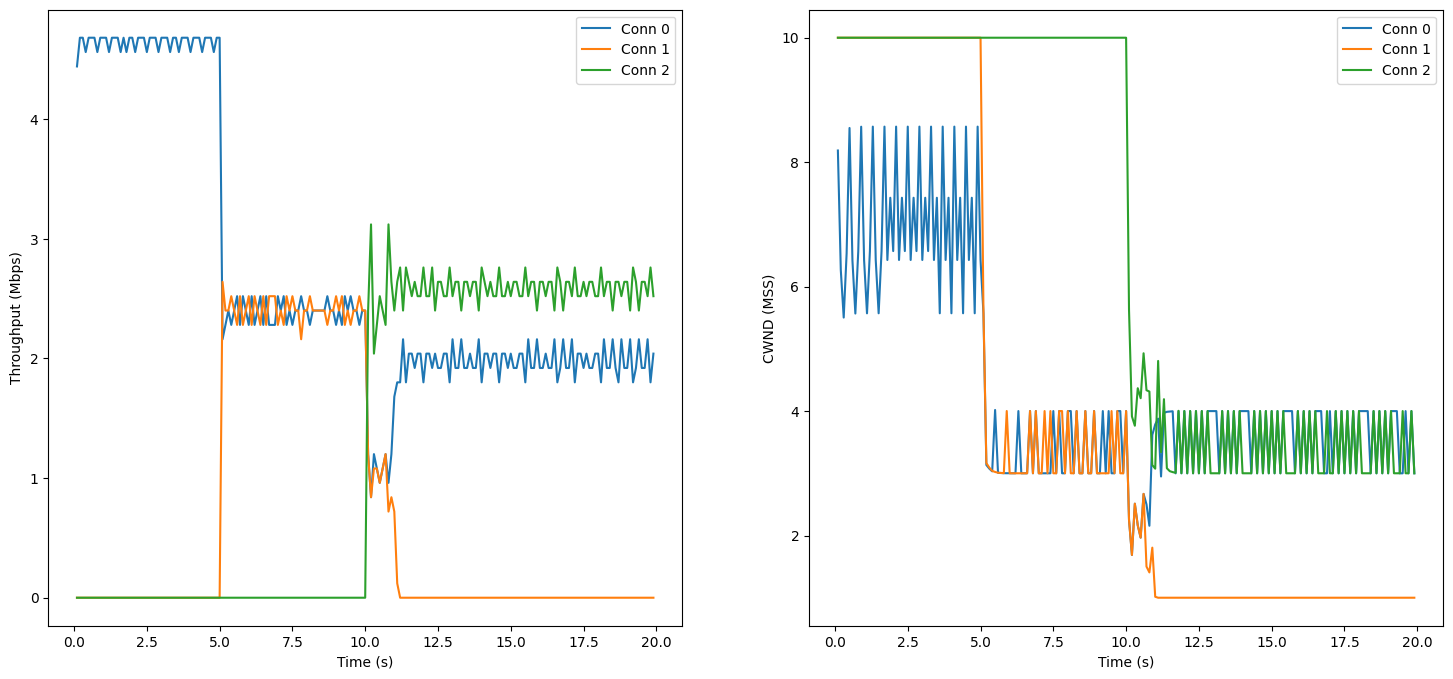

In [72]:
# Deseneaza graficele pentru throughput is cwnd. Figsize poate fi modificat pentru a schimba dimensiunea figurilor.
fig, axs = plt.subplots(ncols=2, figsize=(18, 8))

plot_throughput(axs[0], num_cons)
plot_cwnd(axs[1], num_cons)
plt.show()

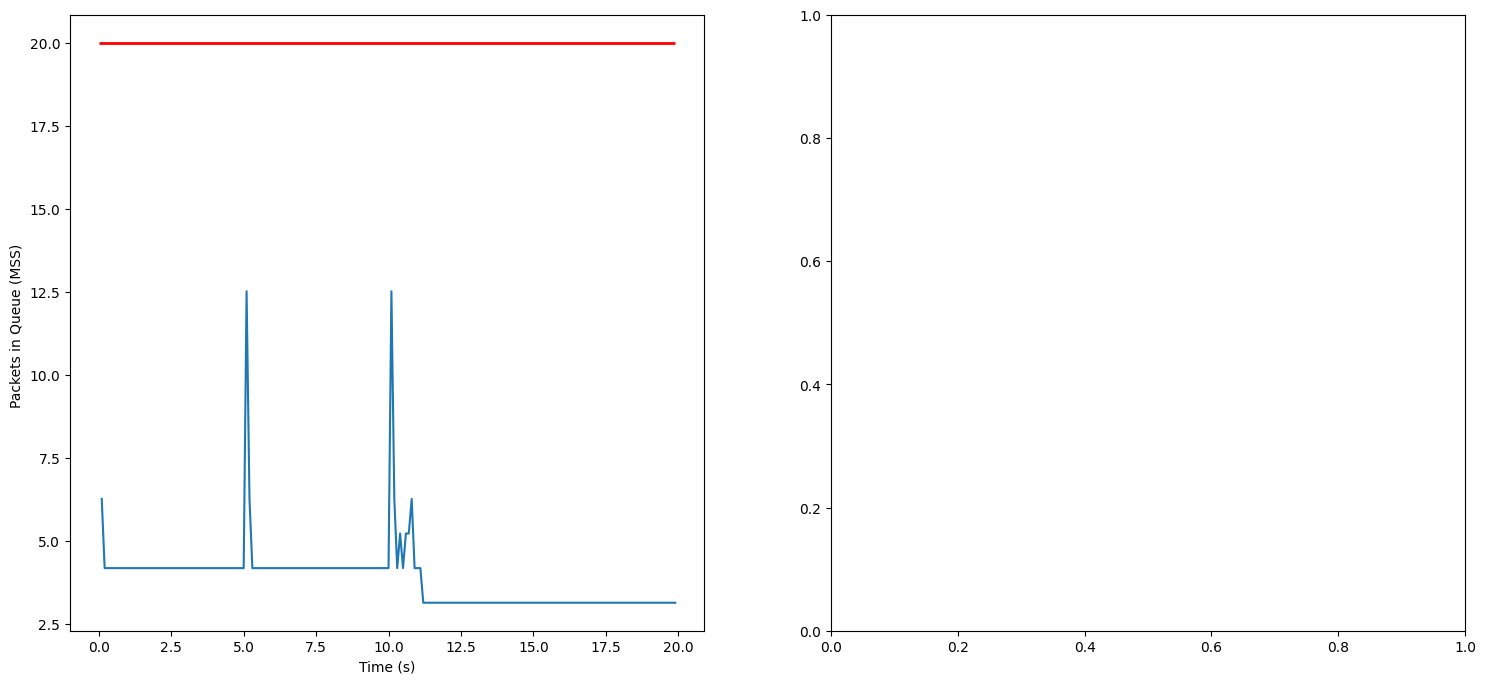

In [73]:
# Deseneaza dimensiunea cozii din router in MSS.
fig, axs = plt.subplots(ncols=2, figsize=(18, 8))

plot_router_queue(axs[0], router_queue_size)
plt.show()

## Masurarea performantei pentru clasamentul pe serie

Pentru a face distinctia intre implementari, vom acorda un scor de performanta algoritmului. Scorul este impartit in 3 categorii:

* thrghouput (300p)
* fairness (300p)
* latenta (300p)

In [74]:
# Functii helper folosite pentru a calcula valori precum average thrghouput
import math

# Calcuelaza average-ul dintr-o coloana dintr-un fisier .dat
def avg_col(data_path, col, scale):
        x1 = []
        with open(data_path) as f:
            for line in f:
                values = line.split()
                x1.append(float(values[col]) * scale)
        return sum(x1)/(len(x1))

# Afiseaza throughput-ul pentru o conexiune si traseazao linie orizontala la valoarea ideala.
def plot_throughput2(axs, data_path, bandwidth):
    axs.set_ylabel('Throughput (Mbps)')
    axs.set_xlabel('Time (s)')
    x1 = []
    y1 = []
    with open(data_path) as f:
        for line in f:
            values = line.split()
            x1.append(float(values[0]))
            y1.append(float(values[12]) * 8 / 1000000)
            
    axs.hlines(y=bandwidth, xmin=0, xmax=x1[-1], linewidth=2, color='r')
    # Ca sa arata graficul mai bine, nu luam in considerare primele 4 tick-uri
    axs.plot(x1[4:], y1[4:], '-')
    
# Afiseaza throughput-ul dintr-un anumit folder .dat
def plot_throughput_from_data(axs, num_cons, data_folder):
    axs.set_ylabel('Throughput (Mbps)')
    axs.set_xlabel('Time (s)')
    # Valorile din fisieri sunt in byes asa ca le inmultim cu 8/1000000 ca sa trecem in Mb/s
    plot_generic(axs, 0, 12, 'Throughput', 'Time (s)', 8 / 1000000, num_cons, data_folder)

### Throughput (Viteza de transmisie)
Ne intereseaza sa avem un averge thrghouput = BDP. Asta inseamna ca ar trebui sa ajungem 


no_of_conns 1
endtime(ms) 20000
Log interval set to 100ms
Queue size set to 333
Latency set to 4
Bandwidth set to 100Mbps
ECN thresholds set to 33 33
Outputting to logout.dat
CCSinkLoggerSampling(p=0.1 init 
Start flow CCsrc 0 at 0s
..........|..........|..........|......
##### [RESULT] Average thrghouput 95.80763819095465 vs 100 expected
no_of_conns 1
endtime(ms) 20000
Log interval set to 100ms
Queue size set to 416
Latency set to 1
Bandwidth set to 500Mbps
ECN thresholds set to 41 41
Outputting to logout.dat
CCSinkLoggerSampling(p=0.1 init 
Start flow CCsrc 0 at 0s
..........|..........|..........|......
##### [RESULT] Average thrghouput 479.40000000000015 vs 500 expected
no_of_conns 1
endtime(ms) 20000
Log interval set to 100ms
Queue size set to 8333
Latency set to 10
Bandwidth set to 1000Mbps
ECN thresholds set to 833 833
Outputting to logout.dat
CCSinkLoggerSampling(p=0.1 init 
Start flow CCsrc 0 at 0s
..........|..........|..........|......
##### [RESULT] Average thrghouput 952.2

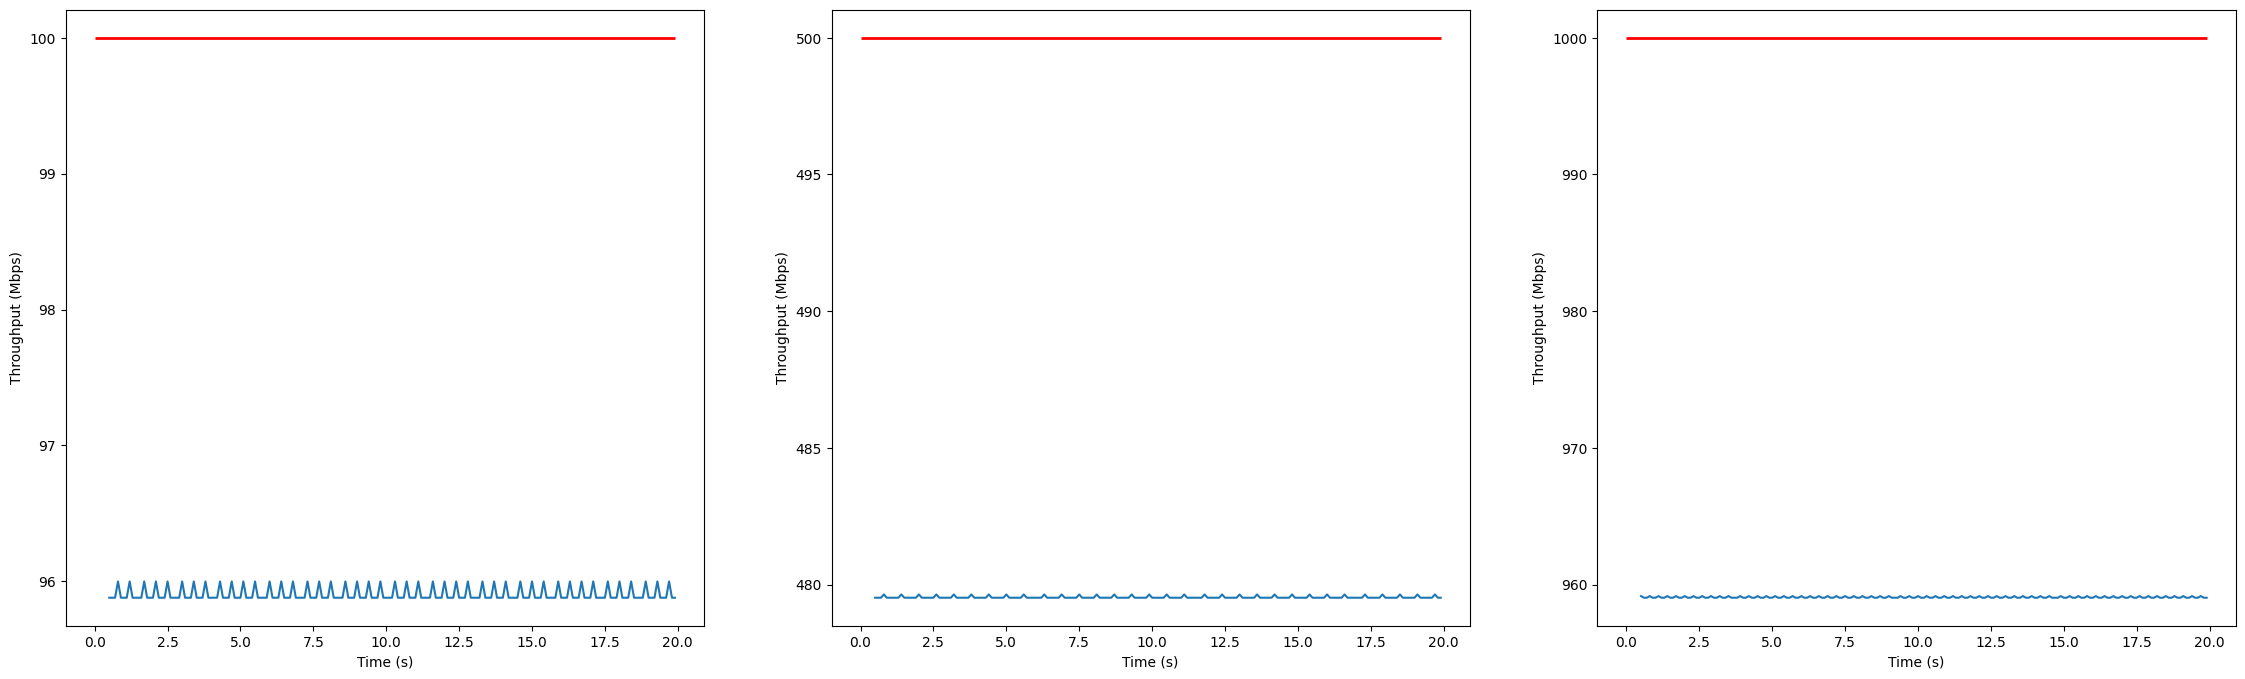

In [75]:
# Urmatoarele trei verifica daca algoritmul de congestie foloseste banda intr-un mod optim

# Vom masura rata de transmisie in diferite combinatii de throughput si latency. Coada de pachete din router are dimensiunea BDP-ului.
MSS = 1500 # in bytes
latency = [4, 1, 10] # ms
bandwidth = [100, 500, 1000] # Mbs
bdp = [ int(((i / 1000) * (j * 10 **6))) for i, j in zip(latency, bandwidth)] # in bits
bdp_in_mss = [int(i / (MSS * 8)) for i in bdp]
queue_size_in_mss = [ int(10 * i / (MSS * 8)) for i in bdp]
avg = []

# Rulam pentru trei scenarii diferite
for i in range(3):
    data_folder = "tmp/thr{}/".format(i)
    # Creeaza directorul in care vom salva rezultatele simularii
    !mkdir -p {data_folder}
    ! ./htsim_dumbell_cc -conns 1 -end 20000 -log 100 -q {queue_size_in_mss[i]} \
         -latency {latency[i]} -bandwidth {bandwidth[i]} -ecn {bdp_in_mss[i]} {bdp_in_mss[i]}; ./scripts/parse.sh logout.dat {data_folder}
    avg.append(avg_col("tmp/thr{}/0.dat".format(i), 12, 8 / 1000000))
    print("\n##### [RESULT] Average thrghouput {} vs {} expected".format(avg[i], bandwidth[i]))

# Calculeaza scorul pentru clasament. Acesta este media la cat am reusit sa acoperim din bandwidth in cele 3 scenarii.
score_thrghouput = (avg[0]/bandwidth[0] + avg[1]/ bandwidth[1] + avg[2]/ bandwidth[2]) * 100
print("+++++ Scorul pentru aceasta categorie: {} puncte".format(score_thrghouput))

# Deseneaza graficele thrghouput-ului. Linia orizontala rosie reprezinta valoarea asteptata.
fig, axs = plt.subplots(ncols=3, figsize=(28, 8))
for i in range(3):
    plot_throughput2(axs[i], "tmp/thr{}/0.dat".format(i), bandwidth[i])
plt.show()


## Fairness

Vrem ca banda sa fie impartita corect intre mai multe conexiuni.

no_of_conns 4
endtime(ms) 80000
Bandwidth set to 50Mbps
Log interval set to 100ms
Queue size set to 1000
Latency set to 5
ECN thresholds set to 20 20
Start delta to 500ms
Outputting to logout.dat
CCSinkLoggerSampling(p=0.1 init 
Start flow CCsrc 0 at 0s
.Start flow CCsrc 1 at 0.5s
Start flow CCsrc 2 at 1s
.Start flow CCsrc 3 at 1.5s
........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|.....
####### Min/Max average thrghouput: 11.339624530663318/12.541426783479325
no_of_conns 8
endtime(ms) 80000
Bandwidth set to 50Mbps
Log interval set to 100ms
Queue size set to 1000
Latency set to 2
ECN thresholds set to 8 8
Start delta to 500ms
Outputting to logout.dat
CCSinkLoggerSampling(p=0.1 init 
Start flow CCsrc 0 at 0s
.Start flow CCsrc 1 at 0.5s
Start flow CCsrc 2 at 1s
.Start flow CCsrc 3 at 1.5s
.Start flow CCsrc 4 at 2s
.Start flow CCsrc 5 at 2.5s
.Start flow CCsrc 6 at 3s
.Start flow CCsrc 7 

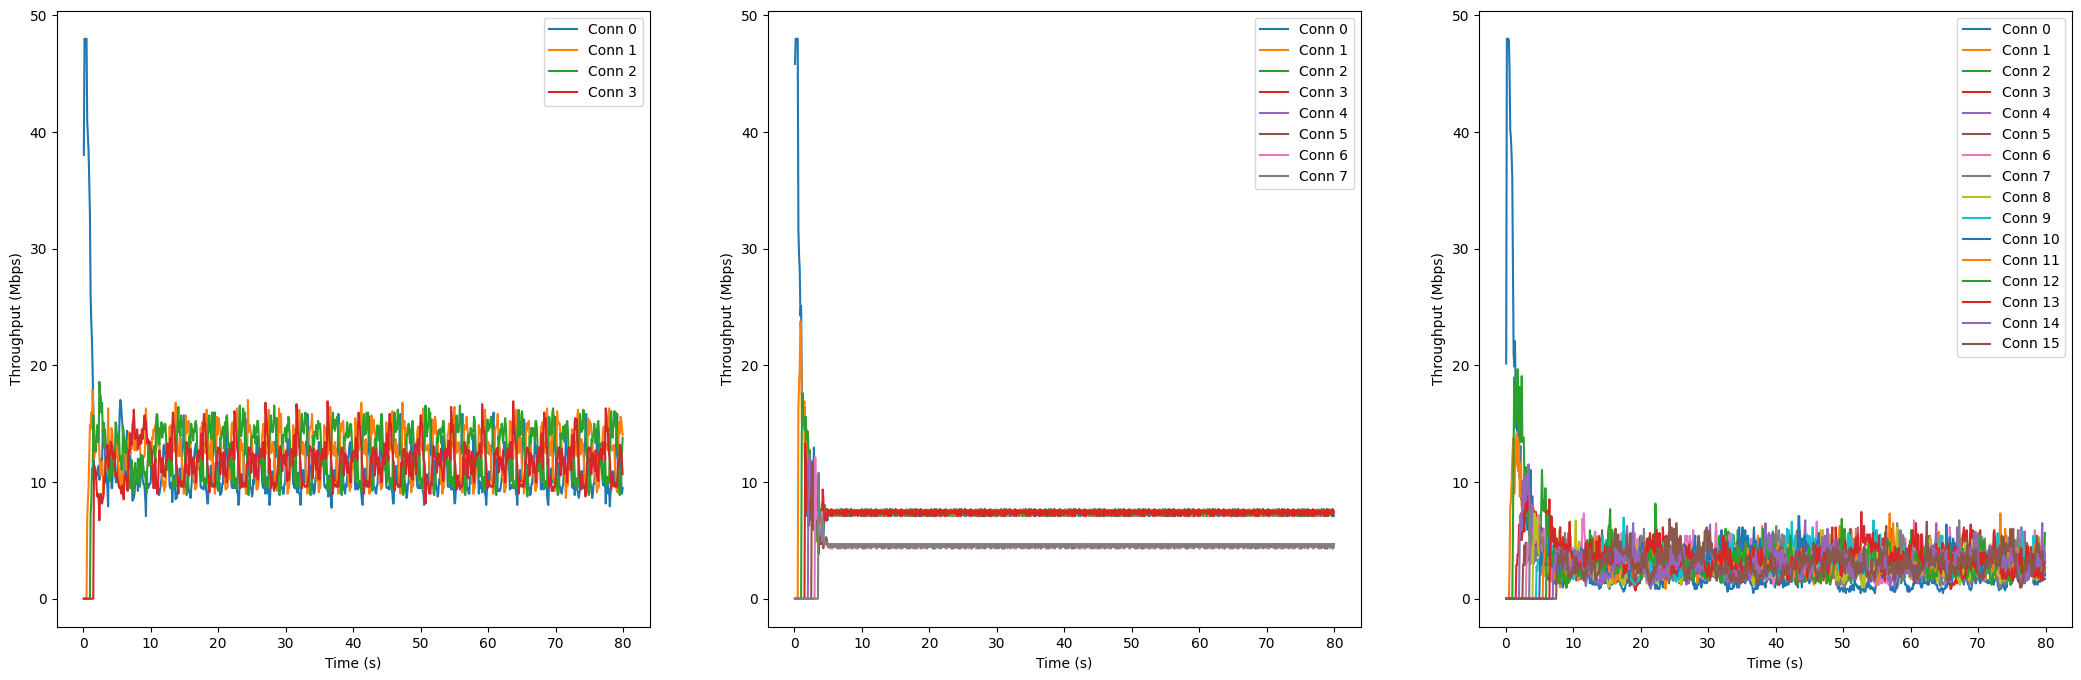

In [76]:
# Urmatorul experiment verifica daca algoritmul imparte in mod egal banda intre mai multe conexiuni.
num_cons = [4, 8, 16]
router_queue_size = 1000 # in MSS
latency = [5, 2, 10]
bandwidth = [50, 50, 50]
bdp = [int(((i / 1000) * (j * 10 **6))) for i, j in zip(latency, bandwidth)] # in bits
bdp_in_mss = [int(i / (MSS * 8)) for i in bdp] # in packets
fairness = []

# Rulam pentru trei scenarii diferite
for i in range(3):
    data_folder = "tmp/fair{}/".format(i)
    !mkdir -p {data_folder}
    # Ruleaza experimentul cu num_cons[i] conexiuni.
    ! ./htsim_dumbell_cc -conns {num_cons[i]} -end 80000  -bandwidth {bandwidth[i]} \
    -log 100 -q {router_queue_size} -latency {latency[i]} -ecn {bdp_in_mss[i]} {bdp_in_mss[i]} \
    -startdelta 500; ./scripts/parse.sh logout.dat {data_folder}
    
    # Calculeaza raportul dintre throughput-ul cel mai mic al uneia dintre conexiuni cu cel mai mare. Ideal acesta ar trebui sa fie 1 pentru ca bandwidth-ul se imparte egal intre toate conexiunile
    avgs = []
    for j in range(num_cons[i]):
        # 8/10000000 pentru a trece in Mbps
        avgs.append(avg_col("tmp/fair{}/{}.dat".format(i, j), 12, 8 / 1000000))

    fairness.append(min(avgs)/max(avgs))
    print("\n####### Min/Max average thrghouput: {}/{}".format(min(avgs), max(avgs)))

score_fairness = (fairness[0] + fairness[1] + fairness[2]) / 3 * 100 * 3
print("+++++ Scorul pentru aceasta categorie: {} puncte".format(score_fairness))

# Deseneaza thoughput-ul pentru conexiuni. Din figsize putem schimba dimensiunea figurilor.
fig, axs = plt.subplots(ncols=3, figsize=(26, 8))
for i in range(3):
    plot_throughput_from_data(axs[i], num_cons[i], "tmp/fair{}/".format(i))
plt.show()

## Latenta


Vom masura latenta in functie de cat de incarcata este coada din router. Astfel, punctajul este acordat in functie de gradul de umplere al cozii.

no_of_conns 2
endtime(ms) 60000
Log interval set to 100ms
Queue size set to 40
Start delta to 200ms
Latency set to 5
Bandwidth set to 10Mbps
ECN thresholds set to 4 4
Outputting to logout.dat
CCSinkLoggerSampling(p=0.1 init 
Start flow CCsrc 0 at 0s
Start flow CCsrc 1 at 0.2s
..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|.........no_of_conns 4
endtime(ms) 60000
Log interval set to 100ms
Queue size set to 200
Start delta to 200ms
Latency set to 5
Bandwidth set to 50Mbps
ECN thresholds set to 20 20
Outputting to logout.dat
CCSinkLoggerSampling(p=0.1 init 
Start flow CCsrc 0 at 0s
Start flow CCsrc 1 at 0.2s
Start flow CCsrc 2 at 0.4s
.Start flow CCsrc 3 at 0.6s
.........|..........|..........|..........|..........|..........|..........|..........|..........|..........|.........no_of_conns 3
endtime(ms) 60000
Log interval set to 100ms
Queue size set to 410
Start delta to 200ms
Latency set to 5
Bandwidth set to 100Mbps
ECN thre

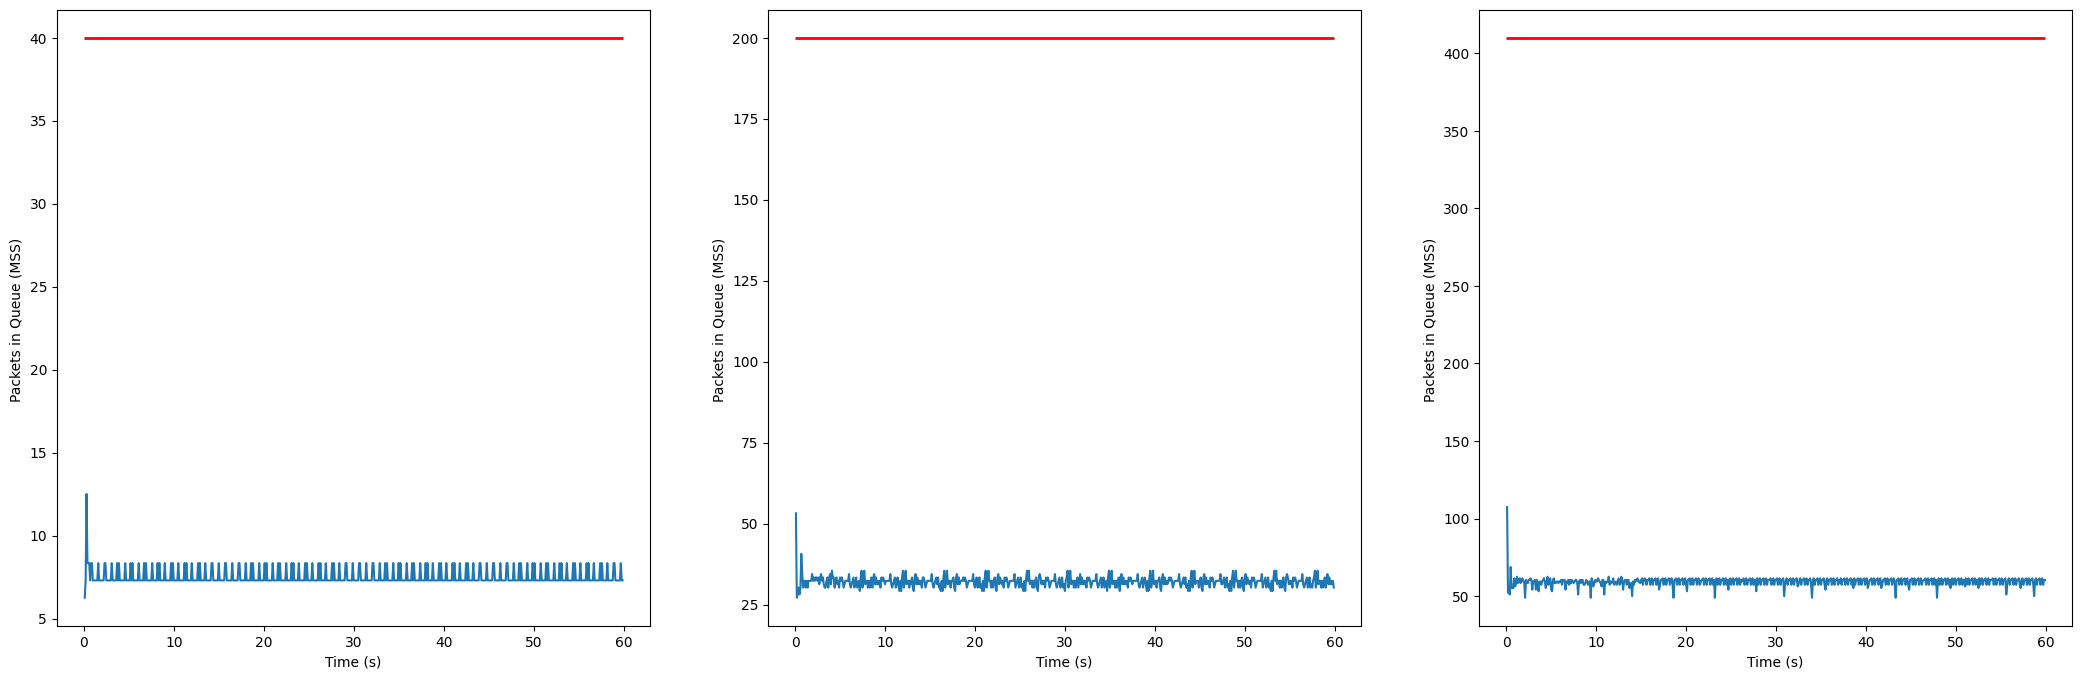

In [77]:
# Acest experiment masoara latenta per pachet introdusa de algoritmul de congestion control. Cu cat avem o coada mai mare de pachete ce asteapta la router
# cu atat latenta va creste.

MSS = 1500 # in bytes
latency = [5, 5, 5] # ms
bandwidth = [10, 50, 100] # Mbs
bdp = [int(((i / 1000) * (j * 10 **6))) for i, j in zip(latency, bandwidth)] # in bits
# Coada din router o sa aiba 10 BDP
bdp_in_mss = [int(i / (MSS * 8)) for i in bdp] # in packets
queue_size_in_mss = [ 10 * int(i / (MSS * 8)) for i in bdp] # 10 BDP queue size in MSS
num_cons = [2, 4, 3]
avgs = []

# Rulam pentru trei scenarii diferite
for i in range(3):
    data_folder = "tmp/lat{}/".format(i)
    !mkdir -p {data_folder}
    ! ./htsim_dumbell_cc -conns {num_cons[i]} -end 60000 -log 100 -q {queue_size_in_mss[i]} -startdelta 200 \
        -latency {latency[i]} -bandwidth {bandwidth[i]} \
        -ecn {bdp_in_mss[i]} {bdp_in_mss[i]} ; ./scripts/parse.sh logout.dat {data_folder}
    # Inmultim coloana 12 (numarul de bytes in buffer-ul routerului) cu1/1500 pentru ca vrem sa masuram in MSS (1500 de bytes)
    avgs.append(avg_col("tmp/lat{}/q.dat".format(i), 12, 1/1500))

score_latency = 300 - (avgs[0] / queue_size_in_mss[0] * 100 + avgs[1] / queue_size_in_mss[1] * 100 + avgs[2] / queue_size_in_mss[2] * 100)
print("\n+++++ Scorul pentru aceasta categorie: {} puncte".format(score_latency))

# Deseneaza numarul de pachete in coada. Linia orizontala reprezinta dimensiunea maxima in MSS a cozii ruterului.
fig, axs = plt.subplots(ncols=3, figsize=(26, 8))
for i in range(3):
    plot_router_queue(axs[i], queue_size_in_mss[i], "tmp/lat{}/".format(i))
plt.show()

# Evlauarea proiectului

Coordonatorul de echipa va incarca arhiva rezultata in urma rularii `create_archive.sh` pe Moodle. Arhiva va include un fisier `team.secret` cu ID-ul secret pe care
l-ati pus la inscriere si un writeup in format pdf. Nota finala la proiect va fi calculata la final in functie de pozitia in clasament si rezultatele la cele trei categorii.

In [78]:
scor_total = score_thrghouput + score_fairness + score_latency
print("Scor total {}/900".format(scor_total))

Scor total 759.8627855203306/900
